# Image search based on visual similarity

## Version 3.0 of the code

### Optimizations
- Instead of calculating KNN distance online lets precompute distance between all the database images.
- Save and reload these precomputed distances.


## Training / Pre-processing code

In [84]:
# Loading required modules

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import os
import numpy as np
from sklearn.externals import joblib
import time
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [85]:
# Define constants

IMGS_PATH = "smalldata\\images\\"

# Size as per VGG16 input layer size
IMGS_WIDTH, IMGS_HEIGHT = 224, 224 

# Max I could run on my PC 10k. Keeping a small size for quick run
DATA_SIZE = 5000

In [86]:
# load VGG16 model with weights from imagenet dataset
vgg_model = vgg16.VGG16(weights='imagenet')

# Take only the last layer which contains the feature vector
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

In [87]:
files = [IMGS_PATH + x for x in os.listdir(IMGS_PATH) if "jpg" in x]

files = files[:DATA_SIZE]

print("Total images:",len(files))

Total images: 5000


In [88]:
imported_imgs = []

for file in files:
    filename = file
    test_img = load_img(filename, target_size=(IMGS_WIDTH, IMGS_HEIGHT))
    np_img = img_to_array(test_img)
    # Add additional axis so that first dimension becomes number images added
    image_batch = np.expand_dims(np_img, axis=0)
        
    imported_imgs.append(image_batch)

# Create vertically stacked images
imgs = np.vstack(imported_imgs)

# Use custom function given by Keras for pre-processing data compatible with ImageNet
processed_imgs = preprocess_input(imgs.copy())

print('Input image array processing done!')
print('Array Size:', processed_imgs.shape)

Input image array processing done!
Array Size: (5000, 224, 224, 3)


In [89]:
# extract the images features

start_time = time.process_time()

# Run the feature extractor on all stacked input images
imgs_features = feat_extractor.predict(processed_imgs)

print("All input image features successfully extracted!")
print('Features matrix size:', imgs_features.shape)
end_time = time.process_time()
print('Time required for extracting features:',(end_time - start_time), 'sec')

All input image features successfully extracted!
Features matrix size: (5000, 4096)
Time required for extracting features: 7971.765625 sec


In [90]:
# Compute cosine similarity between all images
cos_similarities = cosine_similarity(imgs_features)

# Create a pandas dataframe with filename info
cos_similarities_pd = pd.DataFrame(cos_similarities, columns=files, index=files)

# Save pre computed cosine distances
joblib.dump(cos_similarities_pd,'cos_similarities_pd_v30.pkl')

['cos_similarities_pd_v30.pkl']

## Test Code

In [1]:
from keras.preprocessing.image import load_img,img_to_array
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.externals import joblib
import random
import time
import pandas as pd

# number of most similar images to retrieve
N_CLOSEST_IMGS = 10 

DATA_SIZE = 5000

IMGS_PATH = "smalldata\\images\\"

files = [IMGS_PATH + x for x in os.listdir(IMGS_PATH) if "jpg" in x]

files = files[:DATA_SIZE]
print("Total images:",len(files))

Using TensorFlow backend.


Total images: 5000


C:\Users\meetm\anaconda3\envs\tensormay\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def get_similar_images(test_img_index):  
     
    start_time = time.perf_counter()
    
    cos_similarities_pd = joblib.load('cos_similarities_pd_v30.pkl')

    # Get filenames from dataframe
    filenames = list(cos_similarities_pd.index.values.tolist())

    test_img_path = filenames[test_img_index]
    similar_imgs_paths = cos_similarities_pd[test_img_path].sort_values(ascending=False)[1:N_CLOSEST_IMGS+1].index
    similar_imgs_scores = cos_similarities_pd[test_img_path].sort_values(ascending=False)[1:N_CLOSEST_IMGS+1]
    
    
    end_time = time.perf_counter()
    
    print('Execution time for search:',int((end_time-start_time) * 1000),'millisec')
    # Display Test image
    print("***********************************************************************")
    print("Test Image :",test_img_index)
    test_img = load_img(files[test_img_index])
    plt.imshow(test_img)
    plt.show()

    # Display matching images results
    print("***********************************************************************")
    print("Image results based on KNN similarity:")
    # Create a grid of 2x5 to display 10 matching images properly
    f, axarr = plt.subplots(2,5)
    plt.subplots_adjust(right=1.5,hspace=0.5)

    for i in range(0,len(similar_imgs_paths)):
        res = load_img(similar_imgs_paths[i])
        axarr[(i-1)//5][(i-1)%5].imshow(res)
        axarr[(i-1)//5][(i-1)%5].set_title(similar_imgs_scores[i])

test_img_index 2065
Execution time for search: 165 millisec
***********************************************************************
Test Image : 2065


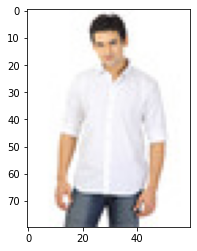

***********************************************************************
Image results based on KNN similarity:


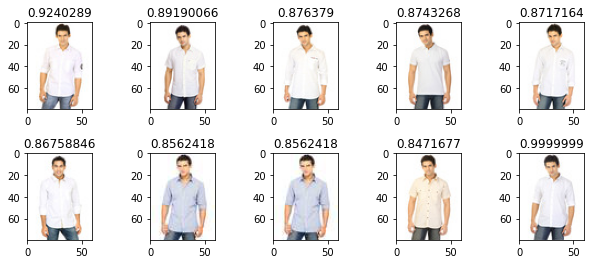

In [4]:
# Get a random test image from given dataset and retrive N_CLOSEST_IMGS similar images
# Alternatively we can also send a completely new test image which is not part of database
test_img_index = random.randint(0,DATA_SIZE)
print('test_img_index',test_img_index)
# Function to search the input test image and display similar results
get_similar_images(test_img_index)